## Using Pystan to fit Model 1. Accessibility with Household and trancportation costs (% of income) ##

We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo. Stan is useful in very high dimensional problems, where there are a large numbers of predictors to infer. In this instance we have over 16,000 rows of data so therefore using Stan's computationally efficient sampling strategies is appropriate.

First lets run a simple linear regression using housing and transportation cost to predict total accessibility at 10 minutes travel time. 

In [5]:
%matplotlib inline
import pystan
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas
import fiona
import seaborn as sns
#import libpysal
import pysal
#import mapclassify as mc
import shapely
from shapely.geometry import Point, Polygon, LineString
sns.set(style="ticks", palette="muted", color_codes=True)

pd.options.display.max_rows = 10

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
Data_clean_all_col = pd.read_csv('Spatial_weights_all.csv', delimiter = ',', encoding='latin-1', converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Data_clean_all_col['GEOID10']=Data_clean_all_col['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Data_clean_all_col.head()

,Unnamed: 0,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fourth_qui,Top_5_perc,perc_below,perc_bel_1,Less_high_,High_schoo,Black_Afri,Hispanic,White_Alon,populati_1
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566


In [4]:
Lag_pred_for_merge = pd.read_csv('Lag_pred_for_merge.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Lag_pred_for_merge['GEOID10']=Lag_pred_for_merge['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Lag_pred_for_merge.head()

,Unnamed: 0,GEOID10,populati_1,yb,lag_ht_ami,lag_Lowest_Qui,lag_Hispanic,lag_Black_Afri,lag_White_Alon,lag_Less_high_,Fit_1_Tot_r_10,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,060371011101000,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
1,2,060371011101007,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
2,3,060371011101008,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
3,4,060371011101011,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
4,5,060371011102004,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,30264.86623,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,93797.41,104498.48,83827.266,88984.016


In [5]:
All_data = Data_clean_all_col.merge(Lag_pred_for_merge,
                                    on='GEOID10')
All_data.head()

,Unnamed: 0_x,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fit_1_Tot_r_10,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,30264.86623,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,93797.41,104498.48,83827.266,88984.016


In [6]:
unique_blocks = All_data.BlockId.unique().tolist()
unique_bgs = All_data.BlockgroupId.unique().tolist()
unique_tracts = All_data.TractId.unique().tolist()

In [7]:
N = len(unique_blocks)
J = len(unique_bgs)
Q = len(unique_tracts)

In [8]:
print(N,J,Q)

16470 3221 1306


In [9]:
block_lookup = dict(zip(unique_blocks, range(N)))
block = block_lookup.values

In [10]:
block_to_bg = dict(Data_clean_all_col[['BlockId', 'BlockgroupId']].values)

In [11]:
block_to_bg_vector = [unique_bgs.index(bg) + 1 for bg in block_to_bg.values()]

In [12]:
bg_to_tract = dict(Data_clean_all_col[['BlockgroupId', 'TractId']].values)

In [13]:
bg_to_tract_vector = [unique_tracts.index(tract) + 1 for tract in bg_to_tract.values()]

In [14]:
tractlevel = np.zeros((Q,1))

In [18]:
varying_intercept_slope = """
data {
  int<lower=0> N; 
  int<lower=0> P_N; 
  int<lower=0> J; 
  int<lower=0> P_J; 
  int<lower=0> Q; 
  int<lower=0> P_Q; 
  int<lower=1, upper=J> block_to_bg[N];
  int<lower=1, upper=Q> bg_to_tract[J];
  vector[N] y;
} 
parameters {
  vector[J] bg_intercept;
  vector[Q] tract_intercept;
  real hypermean;
  real<lower=0> sigma_block;
  real<lower=0> sigma_bg;
  real<lower=0> sigma_tract;
}
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = bg_intercept[block_to_bg[i]];
    
}
model {
  for (j in 1:J)
    bg_intercept[j] ~ normal(tract_intercept[bg_to_tract[j]], sigma_bg);
  y ~ normal(y_hat, sigma_block);
}
"""

In [19]:
data_for_model = dict(
    N = N,
    P_N = 1,
    J = J,
    P_J = 1,
    Q = Q,
    P_Q = 1,
    block_to_bg = block_to_bg_vector,
    bg_to_tract = bg_to_tract_vector,
    y = Data_clean_all_col['Tot_r_10'].values
)

In [20]:
sm1 = pystan.StanModel(model_code=varying_intercept_slope)
fit1 = sm1.sampling(data=data_for_model, 
                    iter=1000, 
                    chains=4, warmup=500, 
                    thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0eac46b52fa25d2aab41379916c1026b NOW.
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/0p/m5mxm89s0wz39hmyq__7qjc00000gn/T/tmplsab2mvv/stanfit4anon_model_0eac46b52fa25d2aab41379916c1026b_5686691477876903046.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/numpy/core/_methods.py:107: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [28]:
pystan.stansummary(fit1)

'Inference for Stan model: anon_model_0eac46b52fa25d2aab41379916c1026b.\n4 chains, each with iter=1000; warmup=500; thin=1; \npost-warmup draws per chain=500, total post-warmup draws=2000.\n\n                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat\nbg_intercept[1]        -4.14   12.22   17.3 -31.43 -19.57  -1.93  11.52  17.01      2  37.54\nbg_intercept[2]        -4.54   11.89  16.84 -30.93 -18.32  -2.48  10.95  16.65      2  21.53\nbg_intercept[3]        -4.47   12.02  17.02 -30.62 -20.16  -3.15  11.59  16.17      2  27.57\nbg_intercept[4]        13.12    8.82  12.52  -2.29   1.67  11.41  25.98  30.01      2  18.31\nbg_intercept[5]        12.95    9.09  12.92  -1.39   0.34  10.49  24.43  31.87      2  16.41\nbg_intercept[6]        15.11   14.62  20.69  -3.37    0.9   6.64   30.8  50.81      2  38.16\nbg_intercept[7]        14.49   13.28  18.81  -3.33   2.61   6.97  28.13  47.61      2  25.24\nbg_intercept[8]         5.05     1.7   2.55   1.24   2.8

In [21]:
with open('./Fit_1/stanmodel_slopes_and_intercepts_model_sm_1.pkl', 'wb') as outfile:
    pickle.dump(sm1, outfile)
with open('./Fit_1/stanmodel_slopes_and_intercepts_result_fit_1.pkl', 'wb') as outfile:
    pickle.dump(fit1, outfile)

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [2]:
import pickle

with open('./Fit_1/stanmodel_slopes_and_intercepts_model_sm_1.pkl', 'rb') as infile:
    sm_1 = pickle.load(infile)


/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:

with open('./Fit_1/stanmodel_slopes_and_intercepts_result_fit_1.pkl', 'rb') as infile:
    fit_1 = pickle.load(infile)

In [6]:
summary_dict = fit_1.summary()
fit1_df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
fit1_df.to_csv('./Fit_1/Predictions_IQR.csv')

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/numpy/core/_methods.py:107: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [7]:
fit1_df.head()

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
bg_intercept[1],-4.142747,12.219254,17.298744,-31.427006,-19.567642,-1.926186,11.518729,17.005467,2.004194,37.541985
bg_intercept[2],-4.544231,11.888053,16.843043,-30.928746,-18.324853,-2.481996,10.946973,16.651337,2.007334,21.527072
bg_intercept[3],-4.471467,12.019181,17.018634,-30.616325,-20.156434,-3.154447,11.588353,16.165994,2.004932,27.574881
bg_intercept[4],13.115907,8.818717,12.515893,-2.285984,1.671746,11.405017,25.980571,30.007353,2.014248,18.314189
bg_intercept[5],12.945606,9.092473,12.915935,-1.389032,0.337739,10.486016,24.430479,31.867759,2.017844,16.411885


In [11]:
bg_intercept_chain, tract_intercept_chain, y_hat_chain, hypermean, sigma_block, sigma_bg, sigma_tract = fit_1.extract(['bg_intercept', 'tract_intercept', 'y_hat', 'hypermean', 'sigma_block', 'sigma_bg', 'sigma_tract']).values()




In [70]:
# Extracting traces
beta = fit_1['sigma_block']
sigma = fit_1['sigma_bg']
lp = fit_1['sigma_tract']

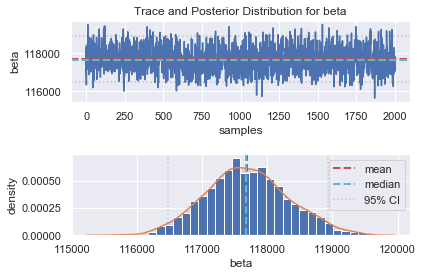

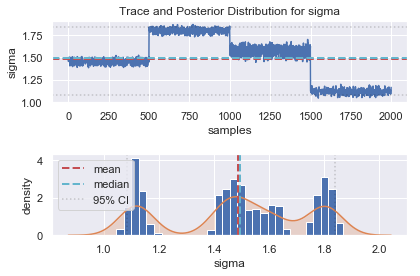

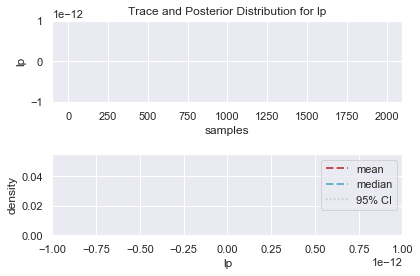

In [71]:

sns.set()


# Nice plot parameters
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
#matplotlib.rc('text', usetex=True)

# Plotting regression line
x_min, x_max = 0, 220000
x_plot = np.linspace(x_min, x_max, 100)

def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()


plot_trace(beta, 'beta') 
plt.show()
plot_trace(sigma, 'sigma') 
plt.show()
plot_trace(lp, 'lp') 
plt.show()

In [49]:
test_1 = fit1.to_dataframe()

In [50]:
test_1.head()

,chain,chain_idx,warmup,divergent__,energy__,treedepth__,accept_stat__,stepsize__,n_leapfrog__,bg_intercept[1],...,y_hat[16462],y_hat[16463],y_hat[16464],y_hat[16465],y_hat[16466],y_hat[16467],y_hat[16468],y_hat[16469],y_hat[16470],lp__
0,1,1,0,1,204992.706809,2,0.796486,0.202582,5,-29.101261,...,-0.570826,-0.570826,-0.570826,-0.570826,-0.570826,-0.570826,-0.570826,-0.570826,-0.570826,-202694.941847
1,1,2,0,1,204938.373866,3,0.912443,0.202582,12,-29.165746,...,-0.924987,-0.924987,-0.924987,-0.924987,-0.924987,-0.924987,-0.924987,-0.924987,-0.924987,-202697.659623
2,1,3,0,1,205017.149692,3,0.913289,0.202582,13,-29.080349,...,-0.963122,-0.963122,-0.963122,-0.963122,-0.963122,-0.963122,-0.963122,-0.963122,-0.963122,-202709.899092
3,1,4,0,1,204876.423671,3,0.896183,0.202582,11,-29.119796,...,-0.826141,-0.826141,-0.826141,-0.826141,-0.826141,-0.826141,-0.826141,-0.826141,-0.826141,-202725.578169
4,1,5,0,1,204952.632355,2,0.830458,0.202582,6,-29.034264,...,-0.821974,-0.821974,-0.821974,-0.821974,-0.821974,-0.821974,-0.821974,-0.821974,-0.821974,-202724.019739


In [51]:
pred_2000_1 = test_1.loc[1999:,'y_hat[1]':'y_hat[16470]']
pred_2000_1

,y_hat[1],y_hat[2],y_hat[3],y_hat[4],y_hat[5],y_hat[6],y_hat[7],y_hat[8],y_hat[9],y_hat[10],...,y_hat[16461],y_hat[16462],y_hat[16463],y_hat[16464],y_hat[16465],y_hat[16466],y_hat[16467],y_hat[16468],y_hat[16469],y_hat[16470]
1999,4.422776,4.422776,4.422776,4.422776,3.364825,3.346834,-2.059384,-2.059384,-2.059384,-1.265557,...,-3.032393,-3.032393,-3.032393,-3.032393,-3.032393,-3.032393,-3.032393,-3.032393,-3.032393,-3.032393


In [52]:
pred_trans_1 = pred_2000_1.transpose()

In [53]:
pred_trans_1.to_csv('./Fit_1/Pred_1_trans.csv')

In [25]:
sigma_b_chain, sigma_bg_chain, sigma_t_chain = fit_1.extract(['sigma_block', 'sigma_bg', 'sigma_tract']).values()

In [26]:
sigma_b = sigma_b_chain[-500:].mean()
sigma_bg = sigma_bg_chain[-500:].mean()
sigma_t = sigma_t_chain[-500:].mean()

In [27]:
block_to_bg_dummies = pd.get_dummies(block_to_bg_vector).values
bg_to_tract_dummies = pd.get_dummies(bg_to_tract_vector).values

In [28]:
block_to_bg_dummies.shape

(16470, 3221)

In [29]:
from scipy import sparse

In [30]:
block_to_bg_sparse = sparse.csc_matrix(block_to_bg_dummies)
bg_to_tract_sparse = sparse.csc_matrix(bg_to_tract_dummies)

In [31]:
full_cov = sparse.identity(len(block_to_bg_vector)) * sigma_b**2 \
           + block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2

In [32]:
diag = full_cov.diagonal()

In [33]:
under_diag = diag**-.5

In [34]:
n = len(block_to_bg_vector)

In [35]:
full_correlation = sparse.identity(n).multiply(under_diag)\
                   @ (full_cov)\
                   @ sparse.identity(n).multiply(under_diag)

In [36]:
np.unique(full_correlation.data).round(10)

array([nan, nan, nan, ..., nan, nan, nan])

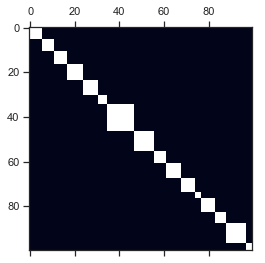

In [37]:
plt.matshow(full_correlation.todense()[:100,:100])
plt.savefig('covariance_fit_1_bg.png')

# Disregarding block-level variation

In [38]:
partial_cov = block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2
           #+ sparse.identity(len(block_to_bg_vector)) * sigma_b \

In [39]:
partial_diag = partial_cov.diagonal() ** -.5

In [40]:
partial_correlation = sparse.identity(n).multiply(partial_diag)\
                       @ (partial_cov)\
                       @ sparse.identity(n).multiply(partial_diag)

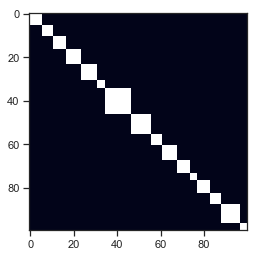

In [41]:
plt.imshow(partial_correlation.todense()[:100,:100])
plt.savefig('covariance_fit_1_no_bg.png')

In [42]:
np.unique(partial_correlation.data)

array([nan, nan, nan, ..., nan, nan, nan])

In [43]:
print(sigma_b**2, sigma_bg**2, sigma_t**2)

13852953746.732233 1.249740020308012 inf


In [44]:
test = fit1.to_dataframe('bg_intercept')

In [45]:
bg_stats = test.median().filter(like='bg_').to_frame('median')
bg_stats['top'] = test.quantile(.975).filter(like='bg_')
bg_stats['bottom'] = test.quantile(.025).filter(like='bg_')

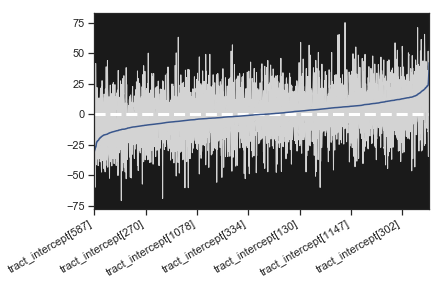

In [54]:
bg_stats.sort_values('median')\
        ['median'].plot(color='#39568C', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
#plt.gca().set_xlim(0,100)
#plt.gca().set_ylim(-100,1000)
plt.savefig("fit_1_catterpillar_bg_intercept.png", format="PNG")

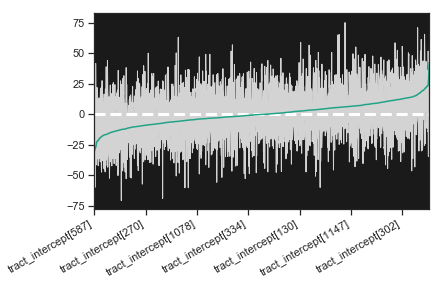

In [48]:
test = fit1.to_dataframe('tract_intercept')

bg_stats = test.median().filter(like='tract_').to_frame('median')
bg_stats['top'] = test.quantile(.975).filter(like='tract_')
bg_stats['bottom'] = test.quantile(.025).filter(like='tract_')

bg_stats.sort_values('median')\
        ['median'].plot(color='#20A387', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
#plt.gca().set_xlim(0,100)
#plt.gca().set_ylim(-100,1000)
plt.savefig("fit_1_catterpillar_tract_intercept.png", format="PNG")